In [8]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp

# from sparrowpy import image_source as ims
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%matplotlib widget

# ruff: noqa: ERA001

Define the parameters and geometry for the simulation.

In [12]:
# room dimensions
import math

# R = 1.5
planeZ = 5  # height of the plane in space
height = 1  # height of the source
min_XY = 0.01  # plane dimensions in meters
max_XY = 100

check_patch_size = 0  # meant as check_plane_dimensions = not check_patch_size
resolution_of_sim = 2  # resolution of the range of simulated geometry
res = max(1, resolution_of_sim)  # min sim res is 10
patch_max_size_structure_inf_plane = 0.3  # cutoff for patch size for large pl
patch_max_size = 2
patch_min_size = 0.05
ir_length_s = 1  # min length otherwise out of bounds refl for first order
sampling_rate = 1000
max_order_k = 0  # no exchange
speed_of_sound = 346.18
absorption = 1  # param default 0.1

# create geometry
# for logspace logspace(-2, 6.64, res, base=2) # length for 0.25 to 100m
min_XY = math.log2(min_XY)
max_XY = math.log2(max_XY)

# circleRes = np.arange(0, 2 * np.pi * R, 0.1)  # circle of 1.5 meters
# probeDims = np.column_stack(
#    (np.cos(circleRes), np.sin(circleRes), [5] * len(circleRes)),
# )
debug__size_plane = np.logspace(min_XY, max_XY, res, base=2)
index_of_8m = (np.abs(debug__size_plane - 8)).argmin()  # 0.25m-100m res30 ~8m [17]

elements = [  # [17/index_of_8m] corner 8.37m
    sp.geometry.Polygon(
        np.array(
            [
                [0, 0, planeZ],
                [0, i, planeZ],
                [i, i, planeZ],
                [i, 0, planeZ],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, 0, 1]),
    )
    for i in np.logspace(min_XY, max_XY, res, base=2)  # length for 0.25 to 100m
]

source_pos = [
    np.array([i / 2, i / 2, planeZ + height]) for i in np.logspace(min_XY, max_XY, res, base=2)
]
sources = [
    sp.geometry.SoundSource(spos, np.array([0, 1, 0]), np.array([0, 0, 1]))
    for spos in source_pos
]
receiver_pos = source_pos  # sub to change

Calculate old slow approach for comparison.

In [ ]:
start = datetime.now()

patch_values = np.arange(
    patch_max_size,
    patch_min_size,
    -(patch_max_size - patch_min_size) / res,
)

if check_patch_size:
    radiPlanes = [
        sp.DRadiosityFast.from_polygon(
            [elements[index_of_8m]],
            i,
        )
        for i in patch_values
    ]
else:
    radiPlanes = [
        sp.DRadiosityFast.from_polygon(
            [element],  # singular element
            (float)(
                np.min(
                    [
                        (np.logspace(min_XY, max_XY, res, base=2)[index] ** 2 / 2000) ** 0.5,
                        patch_max_size_structure_inf_plane,
                    ],
                ),
            ),
        )
        for index, element in enumerate(elements)
    ]

# values for simulation
brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
brdf = sp.brdf.create_from_scattering(
    brdf_sources,
    brdf_receivers,
    pf.FrequencyData(1, [100]),
    pf.FrequencyData(0, [100]),
)


# Initialize histograms
histograms = 0
for indexForRadiPlanes, sim in enumerate(radiPlanes):
    sim.set_wall_scattering([0], brdf, brdf_sources, brdf_receivers)  # len(elements) eq 0

    sim.set_air_attenuation(
        pf.FrequencyData(np.zeros_like(brdf.frequencies), brdf.frequencies)
    )

    sim.set_wall_absorption(
        [0],  # len(elements) eq 0
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies,
        ),
    )

    # calculate from factors including directivity and absorption not need bc only one plane
    # sim.bake_geometry()

    if check_patch_size:
        sim.init_source_energy(
            source_pos[index_of_8m],
        )
    else:
        sim.init_source_energy(
            source_pos[indexForRadiPlanes],  # source_pos[indexForRadiPlanes]
        )

    sim.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        histogram_time_resolution=1 / sampling_rate,
        histogram_length=ir_length_s,
        max_depth=max_order_k,
    )

    # gather energy at receiver  # receiver not as geometry #i.energy_at_receiver
    if check_patch_size:
        histograms += sim.collect_receiver_energy(
            receiver_pos=receiver_pos[index_of_8m],
            speed_of_sound=speed_of_sound,
            histogram_time_resolution=1 / sampling_rate,
            propagation_fx=True,
        )
    else:
        histograms += sim.collect_receiver_energy(
            receiver_pos=receiver_pos[indexForRadiPlanes],
            speed_of_sound=speed_of_sound,
            histogram_time_resolution=1 / sampling_rate,
            propagation_fx=True,
        )


# stop timer
delta = datetime.now() - start
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds * 1e6 + delta.microseconds) / 1e6

C:\Users\klingelnberg\AppData\Local\Temp\ipykernel_15020\3163940130.py:34: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  source_ = pf.samplings.sph_gaussian(sh_order=5)
C:\Users\klingelnberg\AppData\Local\Temp\ipykernel_15020\3163940130.py:36: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  receiver_ = pf.samplings.sph_gaussian(sh_order=5)


MemoryError: Unable to allocate 91.6 GiB for an array with shape (110889, 110889) and data type float64

Diffuse and specular Intensity with plotting

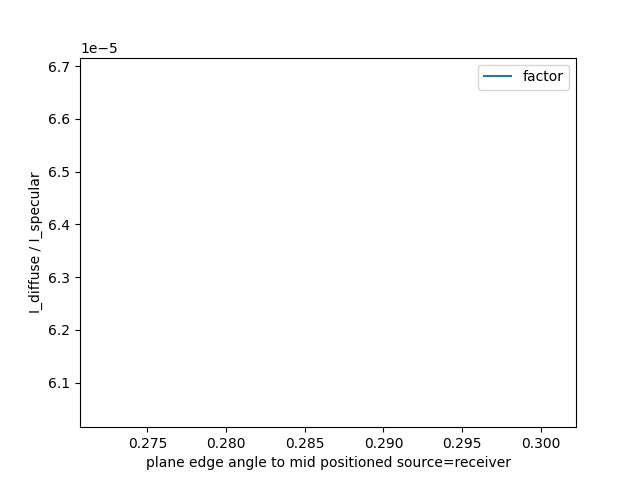

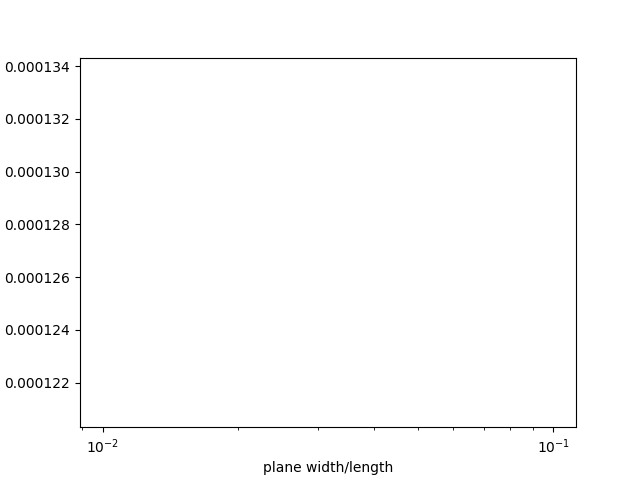

In [11]:
# Signal
I_diffuse_planes = [pf.Signal(i, sampling_rate=sampling_rate) for i in histograms]

I_specular = 1 / (4 * np.pi * (height * 2) ** 2)
factors = [np.sum(i.time[:, :]) / I_specular for i in I_diffuse_planes]

# Plot the factors
plt.figure()
if check_patch_size:
    plt.plot(patch_values, factors, label="factor")
    plt.gca().invert_xaxis()
    plt.xlabel("patch size")
else:
    plt.plot(np.logspace(min_XY, max_XY, res, base=2), factors, label="factor")
    plt.xlabel("plane width/length")
    plt.xscale("log")

    plt.figure()
    plt.plot(
        np.arctan(np.logspace(min_XY, max_XY, res, base=2) / 2 / height) / np.pi * 180,
        [(i / 2) for i in factors],
        label="factor",
    )
    plt.xlabel("plane edge angle to mid positioned source=receiver")
    plt.xscale("linear")

plt.ylabel("I_diffuse / I_specular")
plt.legend()
plt.show()

Find signal points

In [ ]:
%load_ext watermark
%watermark -v -m -iv